# **Xception Model Implementation**

This notebook shows how to run and train an Xception model with Keras. This is how we ran and trained an Xception model and tuned the hyperparameters to receive the best validation accuracy we could. Note that there were many other aspects of tuning the model that could not be shown here, as they were done in many different notebooks due to the nature of deep learning and the time and resources needed for training. The first part of the notebook shows how to train the model, save checkpoints, and save the full model. The second part shows how to look at the model's precision and recall per cell class. It also shows how to plot a confusion matrix for the validation data. Loading in a checkpoint is shown in the Xception_model_load_and_analyze_test_set notebook. There we load in the best checkpoint based on the highest validation accuracy and test the model on the test set. The final weights we used are included in this repository.


## **Connect to Data and Download Libraries**

In [23]:
#Mount GoogleColab to Google Drive. Not a necessary step for those who store the data elsewhere.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#Needed to plot the confusion matrices later
!pip install scikit-plot

### **Download Libraries**

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from skimage import io

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam

# Display
from PIL import Image
import matplotlib.cm as cm

In [ ]:
#Ensure that the gpu is being utilized
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### **Set Up Paths to Data and Check Number of Images**

In [4]:
train_path = '/content/gdrive/MyDrive/210_data/train'
validation_path = '/content/gdrive/MyDrive/210_data/val'
test_path = '/content/gdrive/MyDrive/210_data/test'

SIZE = 400
batch_size = 32

In [5]:
#Number of images in each set 
num_train_images = sum([len(files) for r, d, files in os.walk(train_path)])
num_val_images = sum([len(files) for r, d, files in os.walk(validation_path)])
num_test_images = sum([len(files) for r, d, files in os.walk(test_path)])
num_train_images + num_val_images + num_test_images #check sum adds to 18,365

18365

## **Helper Functions**

In [15]:
def plotImages(images_arr):
  fig, axes = plt.subplots(2,8, figsize = (20,5))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

## **Build Model**

In [7]:
#note that rescaling is not necessary for the Xception model with this data
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.xception.preprocess_input,
    rotation_range=359, 
    horizontal_flip= True, 
    vertical_flip=True, 
    fill_mode='reflect')

In [8]:
validation_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input)

In [9]:
test_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input)

In [11]:
#target size for the Xception model should be (299,299), which is different than the target size of (224,224) for ResNet50
train_generator = train_datagen.flow_from_directory(
        directory = train_path,  # this is the input directory
        target_size=(299, 299),  # all images will be resized to 299x299
        batch_size=batch_size,
        class_mode='categorical')  # multiple categories

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 14687 images belonging to 15 classes.


In [12]:
validation_generator = validation_datagen.flow_from_directory(
    directory = validation_path,
    target_size = (299,299),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 1828 images belonging to 15 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [13]:
test_generator = test_datagen.flow_from_directory(
    directory = test_path,
    target_size = (299,299),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 1850 images belonging to 15 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

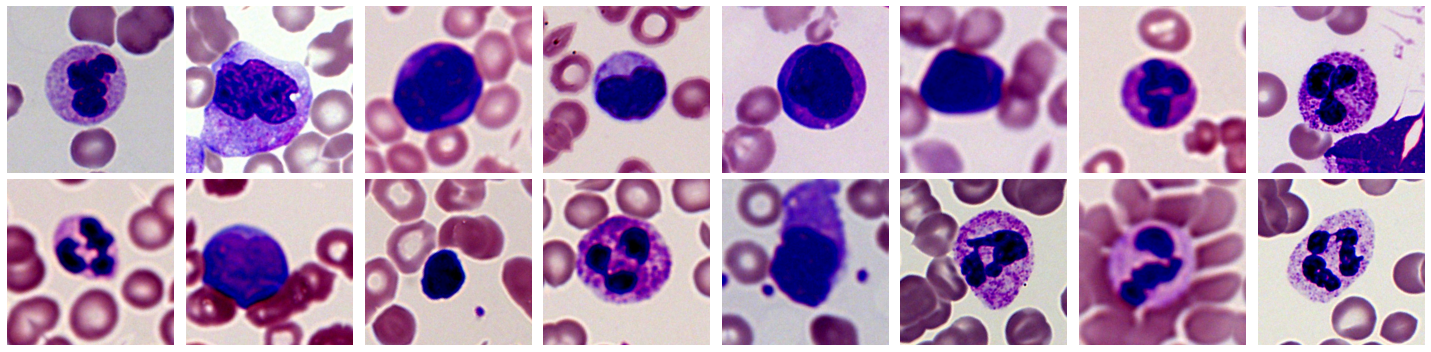

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.

In [16]:
#Look at batch of train images
imgs, labels = next(train_generator)
plotImages(imgs)
print(labels)

In [18]:
#Import Xception model from keras
model = tf.keras.applications.Xception(
    include_top=True,
    weights= None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=15,
    classifier_activation="softmax",
)

In [19]:
#Look at model structure 
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## **Compile and Fit Model**

In [20]:
#implement model.compile
model.compile(loss='categorical_crossentropy',
              optimizer= Adam(learning_rate = 0.0001),
              metrics=['accuracy'])

In [21]:
#run this cell if using google colab and it is the first time running the notebook. If not using google colab,
#change this to a local filepath that works for the environment being used
#!mkdir /content/gdrive/MyDrive/saved_models/100_epochs_xception_size_299

In [ ]:
#Add checkpoints  
#change filepath to match folder created in cell above
from keras.callbacks import ModelCheckpoint

filepath= '/content/gdrive/MyDrive/saved_models/100_epochs_xception_size_299/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5' # File name includes epoch and validation accuracy.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
#Fit the model
model.fit(train_generator,
                    steps_per_epoch = num_train_images//batch_size, #the 2 slashes division return rounded integer
                    epochs = 100,
                    validation_data = validation_generator,
                    validation_steps = num_val_images//batch_size, #the 2 slashes division return rounded integer
                    callbacks = callbacks_list)

In [ ]:
#Save the model - make sure to change this filepath to work with your 
#environment and change each time the model is run
#so that your past saved models are not overwritten
model.save('/content/gdrive/MyDrive/saved_models/100_epochs_xception_size_299_model')

## Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

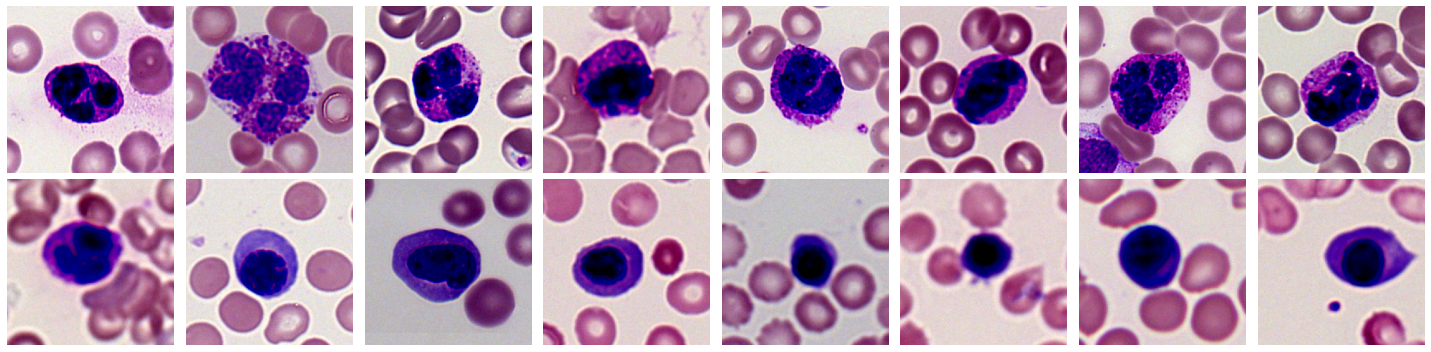

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
#Check out test images for one batch of data
test_imgs, test_labels = next(validation_generator)
plotImages(test_imgs)
print(val_labels)

In [ ]:
#Print the accuracy and loss for validation data
loss,acc = model.evaluate(validation_generator, batch_size = 64 , verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

In [ ]:
#all cell types/labels for val set
validation_generator.classes

In [ ]:
#model predictions
predictions = model.predict(x = validation_generator, verbose = 0)

In [25]:
#get the confusion matrix
cm = confusion_matrix(y_true = validation_generator.classes, y_pred = np.argmax(predictions, axis = -1))

In [26]:
#gives order of cell types 
class_dic = validation_generator.class_indices 
class_dic

{'BAS': 0,
 'EBO': 1,
 'EOS': 2,
 'KSC': 3,
 'LYA': 4,
 'LYT': 5,
 'MMZ': 6,
 'MOB': 7,
 'MON': 8,
 'MYB': 9,
 'MYO': 10,
 'NGB': 11,
 'NGS': 12,
 'PMB': 13,
 'PMO': 14}

In [ ]:
cm_plot_labels = [class_dic.keys()]

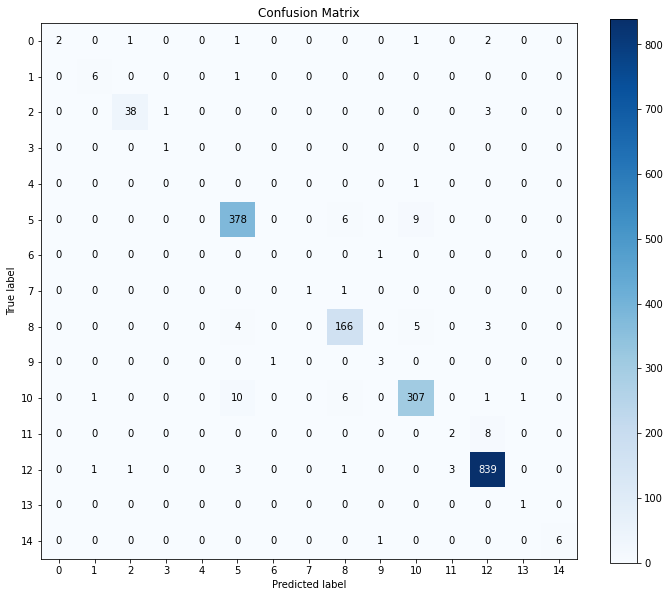

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    validation_generator.classes, 
    np.argmax(predictions, axis = -1),
    figsize=(12,10))

In [ ]:
from sklearn.metrics import classification_report

target_names = ['BAS','EBO','EOS','KSC','LYA','LYT','MMZ','MOB','MON','MYB','MYO','NGB','NGS','PMB','PMO']
print(classification_report(validation_generator.classes, np.argmax(predictions, axis = -1), target_names = target_names))

              precision    recall  f1-score   support

         BAS       1.00      0.29      0.44         7
         EBO       0.75      0.86      0.80         7
         EOS       0.95      0.90      0.93        42
         KSC       0.50      1.00      0.67         1
         LYA       0.00      0.00      0.00         1
         LYT       0.95      0.96      0.96       393
         MMZ       0.00      0.00      0.00         1
         MOB       1.00      0.50      0.67         2
         MON       0.92      0.93      0.93       178
         MYB       0.60      0.75      0.67         4
         MYO       0.95      0.94      0.95       326
         NGB       0.40      0.20      0.27        10
         NGS       0.98      0.99      0.98       848
         PMB       0.50      1.00      0.67         1
         PMO       1.00      0.86      0.92         7

    accuracy                           0.96      1828
   macro avg       0.70      0.68      0.66      1828
weighted avg       0.96   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
#gives order of cell types 
val_dic = validation_generator.class_indices 
val_dic

{'BAS': 0,
 'EBO': 1,
 'EOS': 2,
 'KSC': 3,
 'LYA': 4,
 'LYT': 5,
 'MMZ': 6,
 'MOB': 7,
 'MON': 8,
 'MYB': 9,
 'MYO': 10,
 'NGB': 11,
 'NGS': 12,
 'PMB': 13,
 'PMO': 14}

In [28]:
#invert the val_dic for ease of calling cell names to map for confusion matrix in next cells
inv_val_dic = inv_map = {v: k for k, v in val_dic.items()}
inv_val_dic

{0: 'BAS',
 1: 'EBO',
 2: 'EOS',
 3: 'KSC',
 4: 'LYA',
 5: 'LYT',
 6: 'MMZ',
 7: 'MOB',
 8: 'MON',
 9: 'MYB',
 10: 'MYO',
 11: 'NGB',
 12: 'NGS',
 13: 'PMB',
 14: 'PMO'}

In [29]:
def map_to_labels(array):
    labeled_array = []
    for integer in array:
        labeled_array.append(inv_val_dic[integer])
    return labeled_array



In [30]:
#Plot confusion matrix of different cell types for validation data
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    map_to_labels(validation_generator.classes), 
    map_to_labels(np.argmax(val_predictions, axis = -1)),
    title = "Xception Validation Confusion Matrix",
    figsize=(12,10))